# xgboostを用いてGBDTで分類をやる

GBDT(Gradient Boosting Decision Tree)は、勾配ブースティングの弱学習器を決定木にしたものである。  
決定木を逐次的に（=直前までにできた決定木の情報を全て利用して）構築していくことで、（NN等と比べてお手軽に）高い精度での分類ができることで人気である。

データセットは、Kaggleから  
https://www.kaggle.com/joniarroba/noshowappointments/data  
を用いる。  
これは受診予約のデータセットであり、患者の年齢や性別のほか、予約に現れたかどうかなどが入っている。  
今回は、予約に現れたかどうかを目的変数として分類を行う。

In [ ]:
%matplotlib inline

from datetime import datetime as dt
import matplotlib.pyplot as pyplot

import numpy as np
import scipy as sp
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.grid_search import RandomizedSearchCV

import seaborn

In [2]:
origin_df = pd.read_csv('KaggleV2-May-2016.csv')

## データの様子を見る

In [3]:
origin_df.head(6)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,9.598513e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No


In [4]:
origin_df['No-show'].value_counts()

No     88208
Yes    22319
Name: No-show, dtype: int64

だいたい8:2くらい

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1106fb5f8>,
      dtype=object)

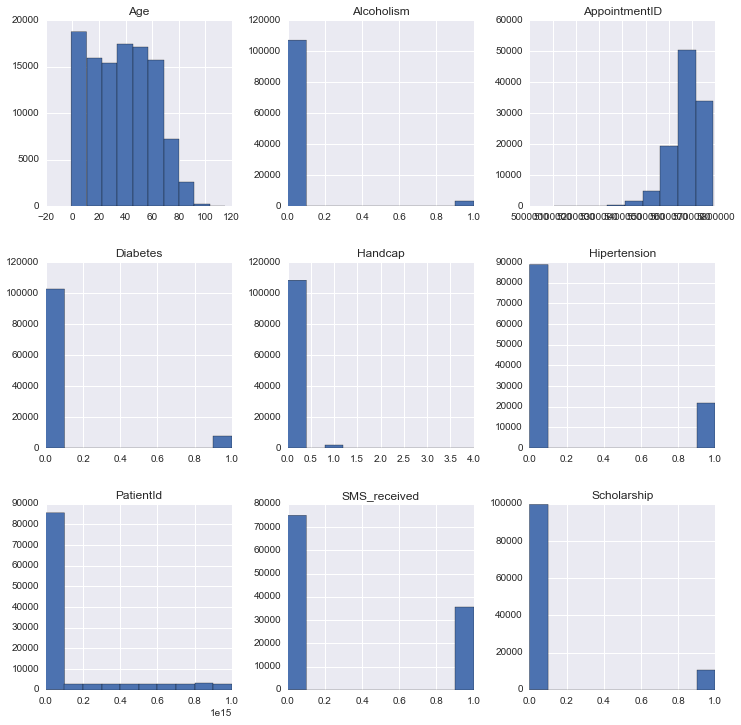

In [5]:
origin_df.hist(figsize=(12, 12))

`age`に負の値があったり、`Handcap`に4があったりして怪しい

## データ整形

In [6]:
df = pd.DataFrame()

予約ぶっちしたら1ということにする

In [7]:
df['Outcome'] = origin_df['No-show'].apply(lambda x: 1 if x == 'Yes' else 0)

In [8]:
df['Age'] = origin_df['Age']

性別は男を1女を0ということにする

In [9]:
df['Male'] = origin_df['Gender'].apply(lambda x: 1 if x == 'M' else 0)

糖尿病

In [10]:
df['Diabetes'] = origin_df['Diabetes']

アルコール依存

In [11]:
df['Alcoholism'] = origin_df['Alcoholism']

高血圧

In [12]:
df['Hipertension'] = origin_df['Hipertension']

なんかハンディキャップ

In [13]:
df['Handicap'] = origin_df['Handcap']

奨学金？

In [14]:
df['Scholarship'] = origin_df['Scholarship']

リマインダ

In [15]:
df['SMS_received'] = origin_df['SMS_received']

曜日を取得  
日曜日は休診日らしくなかったので略

In [16]:
get_weekday = lambda x: dt.strptime(x, '%Y-%m-%dT%H:%M:%SZ').weekday()

In [17]:
df['AppointmentMonday'] = origin_df['AppointmentDay'].apply(lambda x: 1 if get_weekday(x) == 0 else 0)

In [18]:
df['AppointmentTuesday'] = origin_df['AppointmentDay'].apply(lambda x: 1 if get_weekday(x) == 1 else 0)

In [19]:
df['AppointmentWednesday'] = origin_df['AppointmentDay'].apply(lambda x: 1 if get_weekday(x) == 2 else 0)

In [20]:
df['AppointmentThursday'] = origin_df['AppointmentDay'].apply(lambda x: 1 if get_weekday(x) == 3 else 0)

In [21]:
df['AppointmentFriday'] = origin_df['AppointmentDay'].apply(lambda x: 1 if get_weekday(x) == 4 else 0)

In [22]:
df['AppointmentSaturday'] = origin_df['AppointmentDay'].apply(lambda x: 1 if get_weekday(x) == 5 else 0)

相関係数取得  
リマインダするとぶっちが発生しやすくなるという謎  
ぶっちしそうな人にリマインダを送るようなアルゴリズムなのだろうか

/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


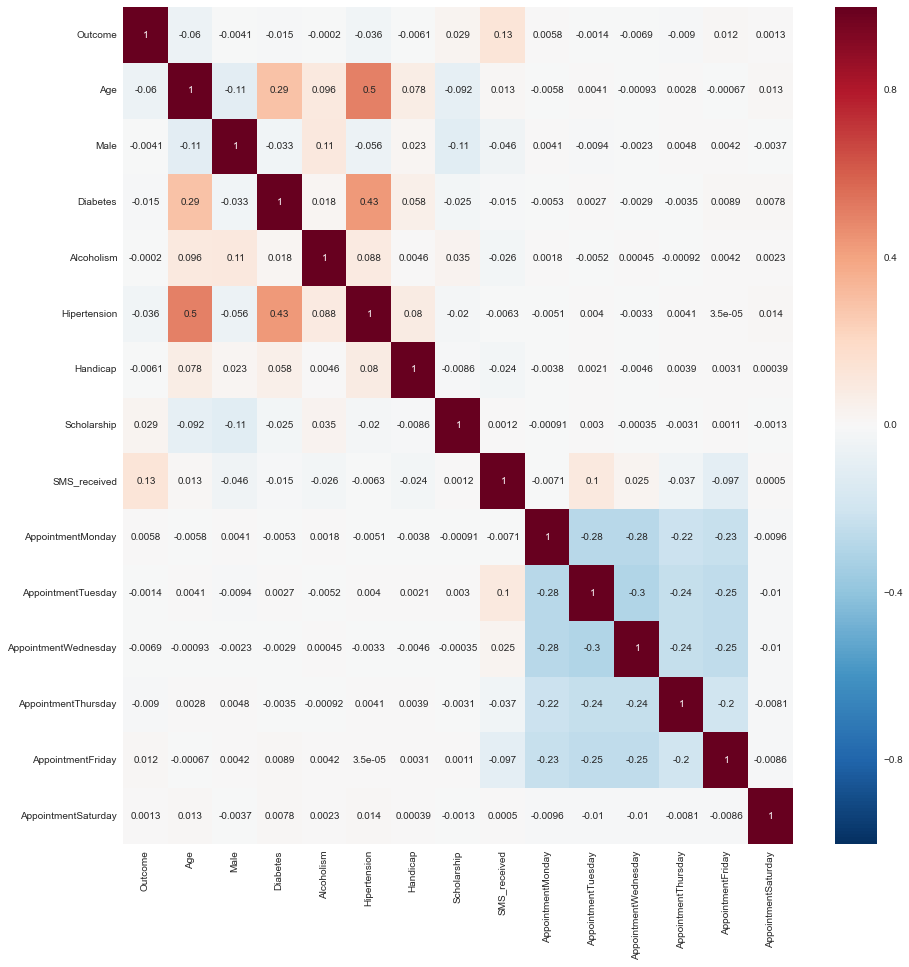

In [23]:
pyplot.figure(figsize=(15,15))
seaborn.heatmap(df.corr(), annot=True)

学習データとテストデータを分離

In [24]:
X = df.ix[:, 'Age':]
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


## 分類

ひとまずデフォルト設定でやってみる

In [25]:
model = xgb.XGBClassifier()

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

評価を見てみる  
スコアは正解率  
8割偏っているので全部0と予測すれば8割は取れる  
f値も見ていきたい

In [26]:
print(model.score(X_train, y_train))

print(model.score(X_test, y_test))

0.7972736594487002
0.8016430225825131


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


テストデータのほうが精度いいとかやる気あんのか  
混合行列をみてみる

In [27]:
print(confusion_matrix(y_test, model.predict(X_test)))

print(f1_score(y_test, model.predict(X_test)))

[[22139    13]
 [ 5468    12]]
0.004359673024523161


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


あっはい  
一応変数の重要度を見てみる

([<matplotlib.axis.YTick at 0x10d2488d0>,
 <a list of 14 Text yticklabel objects>)

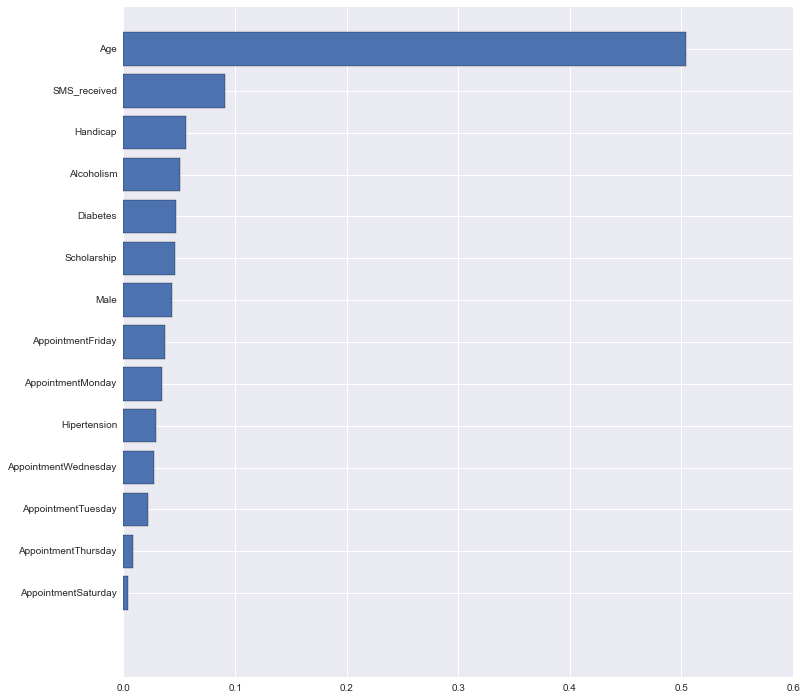

In [28]:
values, names = zip(*sorted(zip(model.feature_importances_, X.columns)))

pyplot.figure(figsize=(12,12))
pyplot.barh(range(len(names)), values, align='center')
pyplot.yticks(range(len(names)), names)

### 説明変数増やしてみる

うーん、「予約した日から来院すべき日までの日数」とか求めてみる

In [29]:
get_date = lambda x: dt.strptime(x, '%Y-%m-%dT%H:%M:%SZ').date()

In [30]:
temp_df = pd.DataFrame()

In [31]:
temp_df['ScheduledDay'] = origin_df['ScheduledDay'].apply(lambda x: get_date(x))

In [32]:
temp_df['AppointmentDay'] = origin_df['AppointmentDay'].apply(lambda x: get_date(x))

In [33]:
df['AwaitingDays'] = (temp_df['AppointmentDay'] - temp_df['ScheduledDay']).apply(lambda x: x.days)

相関みる

/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


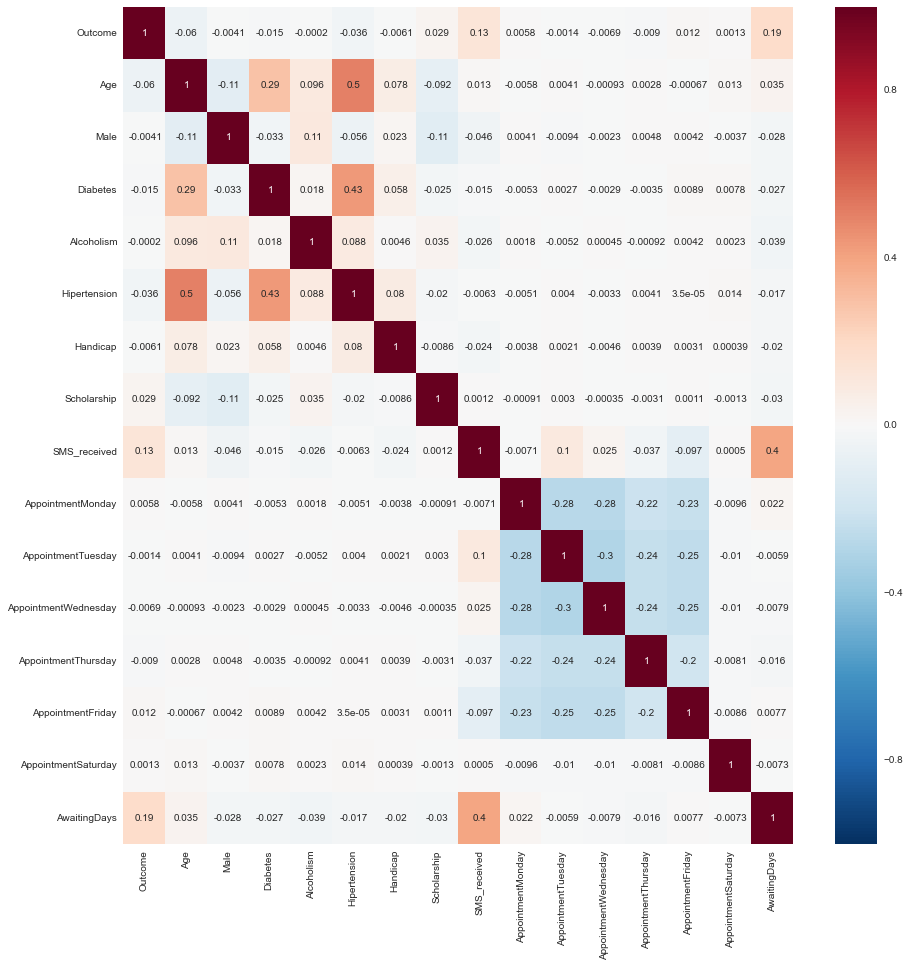

In [34]:
pyplot.figure(figsize=(15,15))
seaborn.heatmap(df.corr(), annot=True)

よさそう

In [35]:
X = df.ix[:, 'Age':]
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [36]:
model = xgb.XGBClassifier()

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [37]:
print(model.score(X_train, y_train))

print(model.score(X_test, y_test))

0.7974546112552023
0.8014258830341633


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [38]:
print(confusion_matrix(y_test, model.predict(X_test)))

print(f1_score(y_test, model.predict(X_test)))

[[22128    24]
 [ 5463    17]]
0.006158304654953812


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


良くはなったけどさ、微差では？

### パラメータ調整

あんまり期待できないけどとりあえず調整しよう

In [39]:
sp.stats.uniform(0.1, 0.4)

In [52]:
params = {
    'learning_rate': sp.stats.uniform(0.01, 0.2),
    'max_depth': sp.stats.randint(3, 11), # 木の深さの最大値
    'subsample': sp.stats.uniform(0.5, 0.5), # サブサンプルを生成するときの学習データの抽出割合
    'min_child_weight': sp.stats.randint(1, 5), # 重み最小
    'max_delta_step': sp.stats.randint(1, 11), #外れ値に強くなる
    'colsample_bytree': sp.stats.uniform(0.5, 0.5) # サブサンプルの割合
}

In [54]:
cv = RandomizedSearchCV(xgb.XGBClassifier(), params, cv=5, scoring= 'f1', n_jobs =1, verbose=2, n_iter=50)

In [ ]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] colsample_bytree=0.8220690060854705, learning_rate=0.1831987660747445, max_delta_step=4, max_depth=4, min_child_weight=4, subsample=0.9502084499922052 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  colsample_bytree=0.8220690060854705, learning_rate=0.1831987660747445, max_delta_step=4, max_depth=4, min_child_weight=4, subsample=0.9502084499922052 -   1.1s
[CV] colsample_bytree=0.8220690060854705, learning_rate=0.1831987660747445, max_delta_step=4, max_depth=4, min_child_weight=4, subsample=0.9502084499922052 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8220690060854705, learning_rate=0.1831987660747445, max_delta_step=4, max_depth=4, min_child_weight=4, subsample=0.9502084499922052 -   1.0s
[CV] colsample_bytree=0.8220690060854705, learning_rate=0.1831987660747445, max_delta_step=4, max_depth=4, min_child_weight=4, subsample=0.9502084499922052 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8220690060854705, learning_rate=0.1831987660747445, max_delta_step=4, max_depth=4, min_child_weight=4, subsample=0.9502084499922052 -   1.1s
[CV] colsample_bytree=0.8220690060854705, learning_rate=0.1831987660747445, max_delta_step=4, max_depth=4, min_child_weight=4, subsample=0.9502084499922052 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8220690060854705, learning_rate=0.1831987660747445, max_delta_step=4, max_depth=4, min_child_weight=4, subsample=0.9502084499922052 -   1.2s
[CV] colsample_bytree=0.8220690060854705, learning_rate=0.1831987660747445, max_delta_step=4, max_depth=4, min_child_weight=4, subsample=0.9502084499922052 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8220690060854705, learning_rate=0.1831987660747445, max_delta_step=4, max_depth=4, min_child_weight=4, subsample=0.9502084499922052 -   1.1s
[CV] colsample_bytree=0.7532712771674613, learning_rate=0.16460488906617504, max_delta_step=9, max_depth=4, min_child_weight=1, subsample=0.6785952658323207 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7532712771674613, learning_rate=0.16460488906617504, max_delta_step=9, max_depth=4, min_child_weight=1, subsample=0.6785952658323207 -   1.4s
[CV] colsample_bytree=0.7532712771674613, learning_rate=0.16460488906617504, max_delta_step=9, max_depth=4, min_child_weight=1, subsample=0.6785952658323207 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7532712771674613, learning_rate=0.16460488906617504, max_delta_step=9, max_depth=4, min_child_weight=1, subsample=0.6785952658323207 -   1.7s
[CV] colsample_bytree=0.7532712771674613, learning_rate=0.16460488906617504, max_delta_step=9, max_depth=4, min_child_weight=1, subsample=0.6785952658323207 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7532712771674613, learning_rate=0.16460488906617504, max_delta_step=9, max_depth=4, min_child_weight=1, subsample=0.6785952658323207 -   1.4s
[CV] colsample_bytree=0.7532712771674613, learning_rate=0.16460488906617504, max_delta_step=9, max_depth=4, min_child_weight=1, subsample=0.6785952658323207 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7532712771674613, learning_rate=0.16460488906617504, max_delta_step=9, max_depth=4, min_child_weight=1, subsample=0.6785952658323207 -   1.5s
[CV] colsample_bytree=0.7532712771674613, learning_rate=0.16460488906617504, max_delta_step=9, max_depth=4, min_child_weight=1, subsample=0.6785952658323207 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7532712771674613, learning_rate=0.16460488906617504, max_delta_step=9, max_depth=4, min_child_weight=1, subsample=0.6785952658323207 -   1.4s
[CV] colsample_bytree=0.5180289752418428, learning_rate=0.1311081297457934, max_delta_step=8, max_depth=7, min_child_weight=3, subsample=0.8981995278110977 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5180289752418428, learning_rate=0.1311081297457934, max_delta_step=8, max_depth=7, min_child_weight=3, subsample=0.8981995278110977 -   1.7s
[CV] colsample_bytree=0.5180289752418428, learning_rate=0.1311081297457934, max_delta_step=8, max_depth=7, min_child_weight=3, subsample=0.8981995278110977 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5180289752418428, learning_rate=0.1311081297457934, max_delta_step=8, max_depth=7, min_child_weight=3, subsample=0.8981995278110977 -   1.6s
[CV] colsample_bytree=0.5180289752418428, learning_rate=0.1311081297457934, max_delta_step=8, max_depth=7, min_child_weight=3, subsample=0.8981995278110977 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5180289752418428, learning_rate=0.1311081297457934, max_delta_step=8, max_depth=7, min_child_weight=3, subsample=0.8981995278110977 -   1.8s
[CV] colsample_bytree=0.5180289752418428, learning_rate=0.1311081297457934, max_delta_step=8, max_depth=7, min_child_weight=3, subsample=0.8981995278110977 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5180289752418428, learning_rate=0.1311081297457934, max_delta_step=8, max_depth=7, min_child_weight=3, subsample=0.8981995278110977 -   2.0s
[CV] colsample_bytree=0.5180289752418428, learning_rate=0.1311081297457934, max_delta_step=8, max_depth=7, min_child_weight=3, subsample=0.8981995278110977 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5180289752418428, learning_rate=0.1311081297457934, max_delta_step=8, max_depth=7, min_child_weight=3, subsample=0.8981995278110977 -   1.9s
[CV] colsample_bytree=0.9491495019337564, learning_rate=0.03377186396069162, max_delta_step=10, max_depth=9, min_child_weight=3, subsample=0.7390683107851688 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9491495019337564, learning_rate=0.03377186396069162, max_delta_step=10, max_depth=9, min_child_weight=3, subsample=0.7390683107851688 -   3.8s
[CV] colsample_bytree=0.9491495019337564, learning_rate=0.03377186396069162, max_delta_step=10, max_depth=9, min_child_weight=3, subsample=0.7390683107851688 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9491495019337564, learning_rate=0.03377186396069162, max_delta_step=10, max_depth=9, min_child_weight=3, subsample=0.7390683107851688 -   3.6s
[CV] colsample_bytree=0.9491495019337564, learning_rate=0.03377186396069162, max_delta_step=10, max_depth=9, min_child_weight=3, subsample=0.7390683107851688 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9491495019337564, learning_rate=0.03377186396069162, max_delta_step=10, max_depth=9, min_child_weight=3, subsample=0.7390683107851688 -   3.1s
[CV] colsample_bytree=0.9491495019337564, learning_rate=0.03377186396069162, max_delta_step=10, max_depth=9, min_child_weight=3, subsample=0.7390683107851688 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9491495019337564, learning_rate=0.03377186396069162, max_delta_step=10, max_depth=9, min_child_weight=3, subsample=0.7390683107851688 -   3.1s
[CV] colsample_bytree=0.9491495019337564, learning_rate=0.03377186396069162, max_delta_step=10, max_depth=9, min_child_weight=3, subsample=0.7390683107851688 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9491495019337564, learning_rate=0.03377186396069162, max_delta_step=10, max_depth=9, min_child_weight=3, subsample=0.7390683107851688 -   3.9s
[CV] colsample_bytree=0.9385100014317307, learning_rate=0.08999805088788854, max_delta_step=9, max_depth=8, min_child_weight=4, subsample=0.5623642864875342 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9385100014317307, learning_rate=0.08999805088788854, max_delta_step=9, max_depth=8, min_child_weight=4, subsample=0.5623642864875342 -   3.6s
[CV] colsample_bytree=0.9385100014317307, learning_rate=0.08999805088788854, max_delta_step=9, max_depth=8, min_child_weight=4, subsample=0.5623642864875342 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9385100014317307, learning_rate=0.08999805088788854, max_delta_step=9, max_depth=8, min_child_weight=4, subsample=0.5623642864875342 -   2.8s
[CV] colsample_bytree=0.9385100014317307, learning_rate=0.08999805088788854, max_delta_step=9, max_depth=8, min_child_weight=4, subsample=0.5623642864875342 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9385100014317307, learning_rate=0.08999805088788854, max_delta_step=9, max_depth=8, min_child_weight=4, subsample=0.5623642864875342 -   2.7s
[CV] colsample_bytree=0.9385100014317307, learning_rate=0.08999805088788854, max_delta_step=9, max_depth=8, min_child_weight=4, subsample=0.5623642864875342 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9385100014317307, learning_rate=0.08999805088788854, max_delta_step=9, max_depth=8, min_child_weight=4, subsample=0.5623642864875342 -   3.0s
[CV] colsample_bytree=0.9385100014317307, learning_rate=0.08999805088788854, max_delta_step=9, max_depth=8, min_child_weight=4, subsample=0.5623642864875342 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9385100014317307, learning_rate=0.08999805088788854, max_delta_step=9, max_depth=8, min_child_weight=4, subsample=0.5623642864875342 -   3.2s
[CV] colsample_bytree=0.8541816552128632, learning_rate=0.16637204115153362, max_delta_step=5, max_depth=8, min_child_weight=3, subsample=0.923217290009494 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8541816552128632, learning_rate=0.16637204115153362, max_delta_step=5, max_depth=8, min_child_weight=3, subsample=0.923217290009494 -   2.7s
[CV] colsample_bytree=0.8541816552128632, learning_rate=0.16637204115153362, max_delta_step=5, max_depth=8, min_child_weight=3, subsample=0.923217290009494 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8541816552128632, learning_rate=0.16637204115153362, max_delta_step=5, max_depth=8, min_child_weight=3, subsample=0.923217290009494 -   2.5s
[CV] colsample_bytree=0.8541816552128632, learning_rate=0.16637204115153362, max_delta_step=5, max_depth=8, min_child_weight=3, subsample=0.923217290009494 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8541816552128632, learning_rate=0.16637204115153362, max_delta_step=5, max_depth=8, min_child_weight=3, subsample=0.923217290009494 -   2.2s
[CV] colsample_bytree=0.8541816552128632, learning_rate=0.16637204115153362, max_delta_step=5, max_depth=8, min_child_weight=3, subsample=0.923217290009494 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8541816552128632, learning_rate=0.16637204115153362, max_delta_step=5, max_depth=8, min_child_weight=3, subsample=0.923217290009494 -   2.1s
[CV] colsample_bytree=0.8541816552128632, learning_rate=0.16637204115153362, max_delta_step=5, max_depth=8, min_child_weight=3, subsample=0.923217290009494 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8541816552128632, learning_rate=0.16637204115153362, max_delta_step=5, max_depth=8, min_child_weight=3, subsample=0.923217290009494 -   2.1s
[CV] colsample_bytree=0.9848530569299614, learning_rate=0.20938281615925838, max_delta_step=1, max_depth=9, min_child_weight=2, subsample=0.6381390880903373 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9848530569299614, learning_rate=0.20938281615925838, max_delta_step=1, max_depth=9, min_child_weight=2, subsample=0.6381390880903373 -   2.9s
[CV] colsample_bytree=0.9848530569299614, learning_rate=0.20938281615925838, max_delta_step=1, max_depth=9, min_child_weight=2, subsample=0.6381390880903373 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9848530569299614, learning_rate=0.20938281615925838, max_delta_step=1, max_depth=9, min_child_weight=2, subsample=0.6381390880903373 -   3.1s
[CV] colsample_bytree=0.9848530569299614, learning_rate=0.20938281615925838, max_delta_step=1, max_depth=9, min_child_weight=2, subsample=0.6381390880903373 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9848530569299614, learning_rate=0.20938281615925838, max_delta_step=1, max_depth=9, min_child_weight=2, subsample=0.6381390880903373 -   3.2s
[CV] colsample_bytree=0.9848530569299614, learning_rate=0.20938281615925838, max_delta_step=1, max_depth=9, min_child_weight=2, subsample=0.6381390880903373 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9848530569299614, learning_rate=0.20938281615925838, max_delta_step=1, max_depth=9, min_child_weight=2, subsample=0.6381390880903373 -   3.4s
[CV] colsample_bytree=0.9848530569299614, learning_rate=0.20938281615925838, max_delta_step=1, max_depth=9, min_child_weight=2, subsample=0.6381390880903373 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9848530569299614, learning_rate=0.20938281615925838, max_delta_step=1, max_depth=9, min_child_weight=2, subsample=0.6381390880903373 -   3.1s
[CV] colsample_bytree=0.5749555057817686, learning_rate=0.20726546087404463, max_delta_step=9, max_depth=10, min_child_weight=2, subsample=0.8784665789595438 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5749555057817686, learning_rate=0.20726546087404463, max_delta_step=9, max_depth=10, min_child_weight=2, subsample=0.8784665789595438 -   2.5s
[CV] colsample_bytree=0.5749555057817686, learning_rate=0.20726546087404463, max_delta_step=9, max_depth=10, min_child_weight=2, subsample=0.8784665789595438 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5749555057817686, learning_rate=0.20726546087404463, max_delta_step=9, max_depth=10, min_child_weight=2, subsample=0.8784665789595438 -   2.1s
[CV] colsample_bytree=0.5749555057817686, learning_rate=0.20726546087404463, max_delta_step=9, max_depth=10, min_child_weight=2, subsample=0.8784665789595438 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5749555057817686, learning_rate=0.20726546087404463, max_delta_step=9, max_depth=10, min_child_weight=2, subsample=0.8784665789595438 -   1.9s
[CV] colsample_bytree=0.5749555057817686, learning_rate=0.20726546087404463, max_delta_step=9, max_depth=10, min_child_weight=2, subsample=0.8784665789595438 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5749555057817686, learning_rate=0.20726546087404463, max_delta_step=9, max_depth=10, min_child_weight=2, subsample=0.8784665789595438 -   2.0s
[CV] colsample_bytree=0.5749555057817686, learning_rate=0.20726546087404463, max_delta_step=9, max_depth=10, min_child_weight=2, subsample=0.8784665789595438 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5749555057817686, learning_rate=0.20726546087404463, max_delta_step=9, max_depth=10, min_child_weight=2, subsample=0.8784665789595438 -   2.0s
[CV] colsample_bytree=0.6461082528565997, learning_rate=0.18125464149328266, max_delta_step=3, max_depth=8, min_child_weight=2, subsample=0.7158128962640034 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6461082528565997, learning_rate=0.18125464149328266, max_delta_step=3, max_depth=8, min_child_weight=2, subsample=0.7158128962640034 -   2.4s
[CV] colsample_bytree=0.6461082528565997, learning_rate=0.18125464149328266, max_delta_step=3, max_depth=8, min_child_weight=2, subsample=0.7158128962640034 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6461082528565997, learning_rate=0.18125464149328266, max_delta_step=3, max_depth=8, min_child_weight=2, subsample=0.7158128962640034 -   2.2s
[CV] colsample_bytree=0.6461082528565997, learning_rate=0.18125464149328266, max_delta_step=3, max_depth=8, min_child_weight=2, subsample=0.7158128962640034 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6461082528565997, learning_rate=0.18125464149328266, max_delta_step=3, max_depth=8, min_child_weight=2, subsample=0.7158128962640034 -   2.1s
[CV] colsample_bytree=0.6461082528565997, learning_rate=0.18125464149328266, max_delta_step=3, max_depth=8, min_child_weight=2, subsample=0.7158128962640034 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6461082528565997, learning_rate=0.18125464149328266, max_delta_step=3, max_depth=8, min_child_weight=2, subsample=0.7158128962640034 -   2.0s
[CV] colsample_bytree=0.6461082528565997, learning_rate=0.18125464149328266, max_delta_step=3, max_depth=8, min_child_weight=2, subsample=0.7158128962640034 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6461082528565997, learning_rate=0.18125464149328266, max_delta_step=3, max_depth=8, min_child_weight=2, subsample=0.7158128962640034 -   2.0s
[CV] colsample_bytree=0.6351645883820018, learning_rate=0.07398628951872731, max_delta_step=6, max_depth=5, min_child_weight=3, subsample=0.6289236805291202 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6351645883820018, learning_rate=0.07398628951872731, max_delta_step=6, max_depth=5, min_child_weight=3, subsample=0.6289236805291202 -   1.4s
[CV] colsample_bytree=0.6351645883820018, learning_rate=0.07398628951872731, max_delta_step=6, max_depth=5, min_child_weight=3, subsample=0.6289236805291202 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6351645883820018, learning_rate=0.07398628951872731, max_delta_step=6, max_depth=5, min_child_weight=3, subsample=0.6289236805291202 -   1.4s
[CV] colsample_bytree=0.6351645883820018, learning_rate=0.07398628951872731, max_delta_step=6, max_depth=5, min_child_weight=3, subsample=0.6289236805291202 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6351645883820018, learning_rate=0.07398628951872731, max_delta_step=6, max_depth=5, min_child_weight=3, subsample=0.6289236805291202 -   1.5s
[CV] colsample_bytree=0.6351645883820018, learning_rate=0.07398628951872731, max_delta_step=6, max_depth=5, min_child_weight=3, subsample=0.6289236805291202 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6351645883820018, learning_rate=0.07398628951872731, max_delta_step=6, max_depth=5, min_child_weight=3, subsample=0.6289236805291202 -   1.4s
[CV] colsample_bytree=0.6351645883820018, learning_rate=0.07398628951872731, max_delta_step=6, max_depth=5, min_child_weight=3, subsample=0.6289236805291202 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6351645883820018, learning_rate=0.07398628951872731, max_delta_step=6, max_depth=5, min_child_weight=3, subsample=0.6289236805291202 -   1.4s
[CV] colsample_bytree=0.8748006855284165, learning_rate=0.17651989376424287, max_delta_step=7, max_depth=9, min_child_weight=3, subsample=0.7391827147546315 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8748006855284165, learning_rate=0.17651989376424287, max_delta_step=7, max_depth=9, min_child_weight=3, subsample=0.7391827147546315 -   2.7s
[CV] colsample_bytree=0.8748006855284165, learning_rate=0.17651989376424287, max_delta_step=7, max_depth=9, min_child_weight=3, subsample=0.7391827147546315 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8748006855284165, learning_rate=0.17651989376424287, max_delta_step=7, max_depth=9, min_child_weight=3, subsample=0.7391827147546315 -   2.7s
[CV] colsample_bytree=0.8748006855284165, learning_rate=0.17651989376424287, max_delta_step=7, max_depth=9, min_child_weight=3, subsample=0.7391827147546315 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8748006855284165, learning_rate=0.17651989376424287, max_delta_step=7, max_depth=9, min_child_weight=3, subsample=0.7391827147546315 -   2.7s
[CV] colsample_bytree=0.8748006855284165, learning_rate=0.17651989376424287, max_delta_step=7, max_depth=9, min_child_weight=3, subsample=0.7391827147546315 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8748006855284165, learning_rate=0.17651989376424287, max_delta_step=7, max_depth=9, min_child_weight=3, subsample=0.7391827147546315 -   2.6s
[CV] colsample_bytree=0.8748006855284165, learning_rate=0.17651989376424287, max_delta_step=7, max_depth=9, min_child_weight=3, subsample=0.7391827147546315 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8748006855284165, learning_rate=0.17651989376424287, max_delta_step=7, max_depth=9, min_child_weight=3, subsample=0.7391827147546315 -   2.7s
[CV] colsample_bytree=0.7413120309648815, learning_rate=0.047096698215669655, max_delta_step=10, max_depth=9, min_child_weight=2, subsample=0.6103991129999844 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7413120309648815, learning_rate=0.047096698215669655, max_delta_step=10, max_depth=9, min_child_weight=2, subsample=0.6103991129999844 -   2.6s
[CV] colsample_bytree=0.7413120309648815, learning_rate=0.047096698215669655, max_delta_step=10, max_depth=9, min_child_weight=2, subsample=0.6103991129999844 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7413120309648815, learning_rate=0.047096698215669655, max_delta_step=10, max_depth=9, min_child_weight=2, subsample=0.6103991129999844 -   2.7s
[CV] colsample_bytree=0.7413120309648815, learning_rate=0.047096698215669655, max_delta_step=10, max_depth=9, min_child_weight=2, subsample=0.6103991129999844 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7413120309648815, learning_rate=0.047096698215669655, max_delta_step=10, max_depth=9, min_child_weight=2, subsample=0.6103991129999844 -   2.7s
[CV] colsample_bytree=0.7413120309648815, learning_rate=0.047096698215669655, max_delta_step=10, max_depth=9, min_child_weight=2, subsample=0.6103991129999844 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7413120309648815, learning_rate=0.047096698215669655, max_delta_step=10, max_depth=9, min_child_weight=2, subsample=0.6103991129999844 -   2.7s
[CV] colsample_bytree=0.7413120309648815, learning_rate=0.047096698215669655, max_delta_step=10, max_depth=9, min_child_weight=2, subsample=0.6103991129999844 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7413120309648815, learning_rate=0.047096698215669655, max_delta_step=10, max_depth=9, min_child_weight=2, subsample=0.6103991129999844 -   2.7s
[CV] colsample_bytree=0.63034213521941, learning_rate=0.17046248012267037, max_delta_step=1, max_depth=4, min_child_weight=4, subsample=0.5602301944354231 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.63034213521941, learning_rate=0.17046248012267037, max_delta_step=1, max_depth=4, min_child_weight=4, subsample=0.5602301944354231 -   1.2s
[CV] colsample_bytree=0.63034213521941, learning_rate=0.17046248012267037, max_delta_step=1, max_depth=4, min_child_weight=4, subsample=0.5602301944354231 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.63034213521941, learning_rate=0.17046248012267037, max_delta_step=1, max_depth=4, min_child_weight=4, subsample=0.5602301944354231 -   1.1s
[CV] colsample_bytree=0.63034213521941, learning_rate=0.17046248012267037, max_delta_step=1, max_depth=4, min_child_weight=4, subsample=0.5602301944354231 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.63034213521941, learning_rate=0.17046248012267037, max_delta_step=1, max_depth=4, min_child_weight=4, subsample=0.5602301944354231 -   1.2s
[CV] colsample_bytree=0.63034213521941, learning_rate=0.17046248012267037, max_delta_step=1, max_depth=4, min_child_weight=4, subsample=0.5602301944354231 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.63034213521941, learning_rate=0.17046248012267037, max_delta_step=1, max_depth=4, min_child_weight=4, subsample=0.5602301944354231 -   1.2s
[CV] colsample_bytree=0.63034213521941, learning_rate=0.17046248012267037, max_delta_step=1, max_depth=4, min_child_weight=4, subsample=0.5602301944354231 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.63034213521941, learning_rate=0.17046248012267037, max_delta_step=1, max_depth=4, min_child_weight=4, subsample=0.5602301944354231 -   1.1s
[CV] colsample_bytree=0.700832893376647, learning_rate=0.17328599073988737, max_delta_step=1, max_depth=9, min_child_weight=4, subsample=0.8518229682441198 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.700832893376647, learning_rate=0.17328599073988737, max_delta_step=1, max_depth=9, min_child_weight=4, subsample=0.8518229682441198 -   2.2s
[CV] colsample_bytree=0.700832893376647, learning_rate=0.17328599073988737, max_delta_step=1, max_depth=9, min_child_weight=4, subsample=0.8518229682441198 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.700832893376647, learning_rate=0.17328599073988737, max_delta_step=1, max_depth=9, min_child_weight=4, subsample=0.8518229682441198 -   2.2s
[CV] colsample_bytree=0.700832893376647, learning_rate=0.17328599073988737, max_delta_step=1, max_depth=9, min_child_weight=4, subsample=0.8518229682441198 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.700832893376647, learning_rate=0.17328599073988737, max_delta_step=1, max_depth=9, min_child_weight=4, subsample=0.8518229682441198 -   2.2s
[CV] colsample_bytree=0.700832893376647, learning_rate=0.17328599073988737, max_delta_step=1, max_depth=9, min_child_weight=4, subsample=0.8518229682441198 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.700832893376647, learning_rate=0.17328599073988737, max_delta_step=1, max_depth=9, min_child_weight=4, subsample=0.8518229682441198 -   2.2s
[CV] colsample_bytree=0.700832893376647, learning_rate=0.17328599073988737, max_delta_step=1, max_depth=9, min_child_weight=4, subsample=0.8518229682441198 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.700832893376647, learning_rate=0.17328599073988737, max_delta_step=1, max_depth=9, min_child_weight=4, subsample=0.8518229682441198 -   2.3s
[CV] colsample_bytree=0.8822714763619601, learning_rate=0.13272690248712643, max_delta_step=1, max_depth=9, min_child_weight=1, subsample=0.704442983240945 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8822714763619601, learning_rate=0.13272690248712643, max_delta_step=1, max_depth=9, min_child_weight=1, subsample=0.704442983240945 -   2.9s
[CV] colsample_bytree=0.8822714763619601, learning_rate=0.13272690248712643, max_delta_step=1, max_depth=9, min_child_weight=1, subsample=0.704442983240945 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8822714763619601, learning_rate=0.13272690248712643, max_delta_step=1, max_depth=9, min_child_weight=1, subsample=0.704442983240945 -   2.8s
[CV] colsample_bytree=0.8822714763619601, learning_rate=0.13272690248712643, max_delta_step=1, max_depth=9, min_child_weight=1, subsample=0.704442983240945 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8822714763619601, learning_rate=0.13272690248712643, max_delta_step=1, max_depth=9, min_child_weight=1, subsample=0.704442983240945 -   2.7s
[CV] colsample_bytree=0.8822714763619601, learning_rate=0.13272690248712643, max_delta_step=1, max_depth=9, min_child_weight=1, subsample=0.704442983240945 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8822714763619601, learning_rate=0.13272690248712643, max_delta_step=1, max_depth=9, min_child_weight=1, subsample=0.704442983240945 -   2.9s
[CV] colsample_bytree=0.8822714763619601, learning_rate=0.13272690248712643, max_delta_step=1, max_depth=9, min_child_weight=1, subsample=0.704442983240945 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.8822714763619601, learning_rate=0.13272690248712643, max_delta_step=1, max_depth=9, min_child_weight=1, subsample=0.704442983240945 -   2.9s
[CV] colsample_bytree=0.7040630869495318, learning_rate=0.16404368745999554, max_delta_step=2, max_depth=3, min_child_weight=2, subsample=0.9748207282072314 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7040630869495318, learning_rate=0.16404368745999554, max_delta_step=2, max_depth=3, min_child_weight=2, subsample=0.9748207282072314 -   0.8s
[CV] colsample_bytree=0.7040630869495318, learning_rate=0.16404368745999554, max_delta_step=2, max_depth=3, min_child_weight=2, subsample=0.9748207282072314 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7040630869495318, learning_rate=0.16404368745999554, max_delta_step=2, max_depth=3, min_child_weight=2, subsample=0.9748207282072314 -   0.8s
[CV] colsample_bytree=0.7040630869495318, learning_rate=0.16404368745999554, max_delta_step=2, max_depth=3, min_child_weight=2, subsample=0.9748207282072314 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7040630869495318, learning_rate=0.16404368745999554, max_delta_step=2, max_depth=3, min_child_weight=2, subsample=0.9748207282072314 -   0.8s
[CV] colsample_bytree=0.7040630869495318, learning_rate=0.16404368745999554, max_delta_step=2, max_depth=3, min_child_weight=2, subsample=0.9748207282072314 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7040630869495318, learning_rate=0.16404368745999554, max_delta_step=2, max_depth=3, min_child_weight=2, subsample=0.9748207282072314 -   0.8s
[CV] colsample_bytree=0.7040630869495318, learning_rate=0.16404368745999554, max_delta_step=2, max_depth=3, min_child_weight=2, subsample=0.9748207282072314 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7040630869495318, learning_rate=0.16404368745999554, max_delta_step=2, max_depth=3, min_child_weight=2, subsample=0.9748207282072314 -   0.8s
[CV] colsample_bytree=0.5888884333801845, learning_rate=0.012694220779145384, max_delta_step=8, max_depth=8, min_child_weight=3, subsample=0.7885855240163836 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  colsample_bytree=0.5888884333801845, learning_rate=0.012694220779145384, max_delta_step=8, max_depth=8, min_child_weight=3, subsample=0.7885855240163836 -   1.8s
[CV] colsample_bytree=0.5888884333801845, learning_rate=0.012694220779145384, max_delta_step=8, max_depth=8, min_child_weight=3, subsample=0.7885855240163836 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  colsample_bytree=0.5888884333801845, learning_rate=0.012694220779145384, max_delta_step=8, max_depth=8, min_child_weight=3, subsample=0.7885855240163836 -   1.7s
[CV] colsample_bytree=0.5888884333801845, learning_rate=0.012694220779145384, max_delta_step=8, max_depth=8, min_child_weight=3, subsample=0.7885855240163836 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  colsample_bytree=0.5888884333801845, learning_rate=0.012694220779145384, max_delta_step=8, max_depth=8, min_child_weight=3, subsample=0.7885855240163836 -   1.8s
[CV] colsample_bytree=0.5888884333801845, learning_rate=0.012694220779145384, max_delta_step=8, max_depth=8, min_child_weight=3, subsample=0.7885855240163836 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  colsample_bytree=0.5888884333801845, learning_rate=0.012694220779145384, max_delta_step=8, max_depth=8, min_child_weight=3, subsample=0.7885855240163836 -   1.7s
[CV] colsample_bytree=0.5888884333801845, learning_rate=0.012694220779145384, max_delta_step=8, max_depth=8, min_child_weight=3, subsample=0.7885855240163836 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  colsample_bytree=0.5888884333801845, learning_rate=0.012694220779145384, max_delta_step=8, max_depth=8, min_child_weight=3, subsample=0.7885855240163836 -   1.7s
[CV] colsample_bytree=0.9541726679780183, learning_rate=0.07914394264351908, max_delta_step=7, max_depth=10, min_child_weight=4, subsample=0.7618543319264136 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9541726679780183, learning_rate=0.07914394264351908, max_delta_step=7, max_depth=10, min_child_weight=4, subsample=0.7618543319264136 -   3.3s
[CV] colsample_bytree=0.9541726679780183, learning_rate=0.07914394264351908, max_delta_step=7, max_depth=10, min_child_weight=4, subsample=0.7618543319264136 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9541726679780183, learning_rate=0.07914394264351908, max_delta_step=7, max_depth=10, min_child_weight=4, subsample=0.7618543319264136 -   3.3s
[CV] colsample_bytree=0.9541726679780183, learning_rate=0.07914394264351908, max_delta_step=7, max_depth=10, min_child_weight=4, subsample=0.7618543319264136 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9541726679780183, learning_rate=0.07914394264351908, max_delta_step=7, max_depth=10, min_child_weight=4, subsample=0.7618543319264136 -   3.1s
[CV] colsample_bytree=0.9541726679780183, learning_rate=0.07914394264351908, max_delta_step=7, max_depth=10, min_child_weight=4, subsample=0.7618543319264136 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9541726679780183, learning_rate=0.07914394264351908, max_delta_step=7, max_depth=10, min_child_weight=4, subsample=0.7618543319264136 -   3.1s
[CV] colsample_bytree=0.9541726679780183, learning_rate=0.07914394264351908, max_delta_step=7, max_depth=10, min_child_weight=4, subsample=0.7618543319264136 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9541726679780183, learning_rate=0.07914394264351908, max_delta_step=7, max_depth=10, min_child_weight=4, subsample=0.7618543319264136 -   3.3s
[CV] colsample_bytree=0.5270916246106395, learning_rate=0.08450388492198212, max_delta_step=1, max_depth=10, min_child_weight=4, subsample=0.8601981816012652 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5270916246106395, learning_rate=0.08450388492198212, max_delta_step=1, max_depth=10, min_child_weight=4, subsample=0.8601981816012652 -   2.1s
[CV] colsample_bytree=0.5270916246106395, learning_rate=0.08450388492198212, max_delta_step=1, max_depth=10, min_child_weight=4, subsample=0.8601981816012652 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5270916246106395, learning_rate=0.08450388492198212, max_delta_step=1, max_depth=10, min_child_weight=4, subsample=0.8601981816012652 -   1.8s
[CV] colsample_bytree=0.5270916246106395, learning_rate=0.08450388492198212, max_delta_step=1, max_depth=10, min_child_weight=4, subsample=0.8601981816012652 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5270916246106395, learning_rate=0.08450388492198212, max_delta_step=1, max_depth=10, min_child_weight=4, subsample=0.8601981816012652 -   1.8s
[CV] colsample_bytree=0.5270916246106395, learning_rate=0.08450388492198212, max_delta_step=1, max_depth=10, min_child_weight=4, subsample=0.8601981816012652 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5270916246106395, learning_rate=0.08450388492198212, max_delta_step=1, max_depth=10, min_child_weight=4, subsample=0.8601981816012652 -   1.8s
[CV] colsample_bytree=0.5270916246106395, learning_rate=0.08450388492198212, max_delta_step=1, max_depth=10, min_child_weight=4, subsample=0.8601981816012652 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5270916246106395, learning_rate=0.08450388492198212, max_delta_step=1, max_depth=10, min_child_weight=4, subsample=0.8601981816012652 -   1.8s
[CV] colsample_bytree=0.5302600882326861, learning_rate=0.130860897017743, max_delta_step=6, max_depth=7, min_child_weight=1, subsample=0.5834576449351039 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5302600882326861, learning_rate=0.130860897017743, max_delta_step=6, max_depth=7, min_child_weight=1, subsample=0.5834576449351039 -   1.6s
[CV] colsample_bytree=0.5302600882326861, learning_rate=0.130860897017743, max_delta_step=6, max_depth=7, min_child_weight=1, subsample=0.5834576449351039 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5302600882326861, learning_rate=0.130860897017743, max_delta_step=6, max_depth=7, min_child_weight=1, subsample=0.5834576449351039 -   1.6s
[CV] colsample_bytree=0.5302600882326861, learning_rate=0.130860897017743, max_delta_step=6, max_depth=7, min_child_weight=1, subsample=0.5834576449351039 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5302600882326861, learning_rate=0.130860897017743, max_delta_step=6, max_depth=7, min_child_weight=1, subsample=0.5834576449351039 -   1.8s
[CV] colsample_bytree=0.5302600882326861, learning_rate=0.130860897017743, max_delta_step=6, max_depth=7, min_child_weight=1, subsample=0.5834576449351039 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5302600882326861, learning_rate=0.130860897017743, max_delta_step=6, max_depth=7, min_child_weight=1, subsample=0.5834576449351039 -   1.6s
[CV] colsample_bytree=0.5302600882326861, learning_rate=0.130860897017743, max_delta_step=6, max_depth=7, min_child_weight=1, subsample=0.5834576449351039 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5302600882326861, learning_rate=0.130860897017743, max_delta_step=6, max_depth=7, min_child_weight=1, subsample=0.5834576449351039 -   1.5s
[CV] colsample_bytree=0.5034348347951377, learning_rate=0.0442524639977468, max_delta_step=4, max_depth=10, min_child_weight=1, subsample=0.7507930718971711 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5034348347951377, learning_rate=0.0442524639977468, max_delta_step=4, max_depth=10, min_child_weight=1, subsample=0.7507930718971711 -   2.2s
[CV] colsample_bytree=0.5034348347951377, learning_rate=0.0442524639977468, max_delta_step=4, max_depth=10, min_child_weight=1, subsample=0.7507930718971711 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5034348347951377, learning_rate=0.0442524639977468, max_delta_step=4, max_depth=10, min_child_weight=1, subsample=0.7507930718971711 -   2.2s
[CV] colsample_bytree=0.5034348347951377, learning_rate=0.0442524639977468, max_delta_step=4, max_depth=10, min_child_weight=1, subsample=0.7507930718971711 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5034348347951377, learning_rate=0.0442524639977468, max_delta_step=4, max_depth=10, min_child_weight=1, subsample=0.7507930718971711 -   2.1s
[CV] colsample_bytree=0.5034348347951377, learning_rate=0.0442524639977468, max_delta_step=4, max_depth=10, min_child_weight=1, subsample=0.7507930718971711 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5034348347951377, learning_rate=0.0442524639977468, max_delta_step=4, max_depth=10, min_child_weight=1, subsample=0.7507930718971711 -   2.1s
[CV] colsample_bytree=0.5034348347951377, learning_rate=0.0442524639977468, max_delta_step=4, max_depth=10, min_child_weight=1, subsample=0.7507930718971711 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5034348347951377, learning_rate=0.0442524639977468, max_delta_step=4, max_depth=10, min_child_weight=1, subsample=0.7507930718971711 -   2.0s
[CV] colsample_bytree=0.5126001916503069, learning_rate=0.08324339517124123, max_delta_step=4, max_depth=9, min_child_weight=2, subsample=0.8290848625739184 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5126001916503069, learning_rate=0.08324339517124123, max_delta_step=4, max_depth=9, min_child_weight=2, subsample=0.8290848625739184 -   1.9s
[CV] colsample_bytree=0.5126001916503069, learning_rate=0.08324339517124123, max_delta_step=4, max_depth=9, min_child_weight=2, subsample=0.8290848625739184 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5126001916503069, learning_rate=0.08324339517124123, max_delta_step=4, max_depth=9, min_child_weight=2, subsample=0.8290848625739184 -   1.8s
[CV] colsample_bytree=0.5126001916503069, learning_rate=0.08324339517124123, max_delta_step=4, max_depth=9, min_child_weight=2, subsample=0.8290848625739184 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5126001916503069, learning_rate=0.08324339517124123, max_delta_step=4, max_depth=9, min_child_weight=2, subsample=0.8290848625739184 -   1.7s
[CV] colsample_bytree=0.5126001916503069, learning_rate=0.08324339517124123, max_delta_step=4, max_depth=9, min_child_weight=2, subsample=0.8290848625739184 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5126001916503069, learning_rate=0.08324339517124123, max_delta_step=4, max_depth=9, min_child_weight=2, subsample=0.8290848625739184 -   1.8s
[CV] colsample_bytree=0.5126001916503069, learning_rate=0.08324339517124123, max_delta_step=4, max_depth=9, min_child_weight=2, subsample=0.8290848625739184 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5126001916503069, learning_rate=0.08324339517124123, max_delta_step=4, max_depth=9, min_child_weight=2, subsample=0.8290848625739184 -   1.7s
[CV] colsample_bytree=0.9665168936876511, learning_rate=0.052718147258844404, max_delta_step=8, max_depth=7, min_child_weight=4, subsample=0.7477356555571446 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9665168936876511, learning_rate=0.052718147258844404, max_delta_step=8, max_depth=7, min_child_weight=4, subsample=0.7477356555571446 -   2.2s
[CV] colsample_bytree=0.9665168936876511, learning_rate=0.052718147258844404, max_delta_step=8, max_depth=7, min_child_weight=4, subsample=0.7477356555571446 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9665168936876511, learning_rate=0.052718147258844404, max_delta_step=8, max_depth=7, min_child_weight=4, subsample=0.7477356555571446 -   2.2s
[CV] colsample_bytree=0.9665168936876511, learning_rate=0.052718147258844404, max_delta_step=8, max_depth=7, min_child_weight=4, subsample=0.7477356555571446 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9665168936876511, learning_rate=0.052718147258844404, max_delta_step=8, max_depth=7, min_child_weight=4, subsample=0.7477356555571446 -   2.2s
[CV] colsample_bytree=0.9665168936876511, learning_rate=0.052718147258844404, max_delta_step=8, max_depth=7, min_child_weight=4, subsample=0.7477356555571446 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9665168936876511, learning_rate=0.052718147258844404, max_delta_step=8, max_depth=7, min_child_weight=4, subsample=0.7477356555571446 -   2.2s
[CV] colsample_bytree=0.9665168936876511, learning_rate=0.052718147258844404, max_delta_step=8, max_depth=7, min_child_weight=4, subsample=0.7477356555571446 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9665168936876511, learning_rate=0.052718147258844404, max_delta_step=8, max_depth=7, min_child_weight=4, subsample=0.7477356555571446 -   2.2s
[CV] colsample_bytree=0.6324235926963218, learning_rate=0.1615684283371806, max_delta_step=2, max_depth=8, min_child_weight=4, subsample=0.7379409933439067 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6324235926963218, learning_rate=0.1615684283371806, max_delta_step=2, max_depth=8, min_child_weight=4, subsample=0.7379409933439067 -   2.1s
[CV] colsample_bytree=0.6324235926963218, learning_rate=0.1615684283371806, max_delta_step=2, max_depth=8, min_child_weight=4, subsample=0.7379409933439067 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6324235926963218, learning_rate=0.1615684283371806, max_delta_step=2, max_depth=8, min_child_weight=4, subsample=0.7379409933439067 -   2.0s
[CV] colsample_bytree=0.6324235926963218, learning_rate=0.1615684283371806, max_delta_step=2, max_depth=8, min_child_weight=4, subsample=0.7379409933439067 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6324235926963218, learning_rate=0.1615684283371806, max_delta_step=2, max_depth=8, min_child_weight=4, subsample=0.7379409933439067 -   2.0s
[CV] colsample_bytree=0.6324235926963218, learning_rate=0.1615684283371806, max_delta_step=2, max_depth=8, min_child_weight=4, subsample=0.7379409933439067 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6324235926963218, learning_rate=0.1615684283371806, max_delta_step=2, max_depth=8, min_child_weight=4, subsample=0.7379409933439067 -   1.9s
[CV] colsample_bytree=0.6324235926963218, learning_rate=0.1615684283371806, max_delta_step=2, max_depth=8, min_child_weight=4, subsample=0.7379409933439067 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6324235926963218, learning_rate=0.1615684283371806, max_delta_step=2, max_depth=8, min_child_weight=4, subsample=0.7379409933439067 -   2.0s
[CV] colsample_bytree=0.6704210673039028, learning_rate=0.14117073672049238, max_delta_step=7, max_depth=4, min_child_weight=1, subsample=0.928057364711897 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6704210673039028, learning_rate=0.14117073672049238, max_delta_step=7, max_depth=4, min_child_weight=1, subsample=0.928057364711897 -   1.0s
[CV] colsample_bytree=0.6704210673039028, learning_rate=0.14117073672049238, max_delta_step=7, max_depth=4, min_child_weight=1, subsample=0.928057364711897 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6704210673039028, learning_rate=0.14117073672049238, max_delta_step=7, max_depth=4, min_child_weight=1, subsample=0.928057364711897 -   1.0s
[CV] colsample_bytree=0.6704210673039028, learning_rate=0.14117073672049238, max_delta_step=7, max_depth=4, min_child_weight=1, subsample=0.928057364711897 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6704210673039028, learning_rate=0.14117073672049238, max_delta_step=7, max_depth=4, min_child_weight=1, subsample=0.928057364711897 -   1.0s
[CV] colsample_bytree=0.6704210673039028, learning_rate=0.14117073672049238, max_delta_step=7, max_depth=4, min_child_weight=1, subsample=0.928057364711897 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6704210673039028, learning_rate=0.14117073672049238, max_delta_step=7, max_depth=4, min_child_weight=1, subsample=0.928057364711897 -   1.0s
[CV] colsample_bytree=0.6704210673039028, learning_rate=0.14117073672049238, max_delta_step=7, max_depth=4, min_child_weight=1, subsample=0.928057364711897 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.6704210673039028, learning_rate=0.14117073672049238, max_delta_step=7, max_depth=4, min_child_weight=1, subsample=0.928057364711897 -   1.0s
[CV] colsample_bytree=0.9922465881838464, learning_rate=0.16082421632588204, max_delta_step=9, max_depth=9, min_child_weight=4, subsample=0.9447182406467995 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9922465881838464, learning_rate=0.16082421632588204, max_delta_step=9, max_depth=9, min_child_weight=4, subsample=0.9447182406467995 -   2.6s
[CV] colsample_bytree=0.9922465881838464, learning_rate=0.16082421632588204, max_delta_step=9, max_depth=9, min_child_weight=4, subsample=0.9447182406467995 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9922465881838464, learning_rate=0.16082421632588204, max_delta_step=9, max_depth=9, min_child_weight=4, subsample=0.9447182406467995 -   2.8s
[CV] colsample_bytree=0.9922465881838464, learning_rate=0.16082421632588204, max_delta_step=9, max_depth=9, min_child_weight=4, subsample=0.9447182406467995 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9922465881838464, learning_rate=0.16082421632588204, max_delta_step=9, max_depth=9, min_child_weight=4, subsample=0.9447182406467995 -   2.8s
[CV] colsample_bytree=0.9922465881838464, learning_rate=0.16082421632588204, max_delta_step=9, max_depth=9, min_child_weight=4, subsample=0.9447182406467995 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9922465881838464, learning_rate=0.16082421632588204, max_delta_step=9, max_depth=9, min_child_weight=4, subsample=0.9447182406467995 -   2.6s
[CV] colsample_bytree=0.9922465881838464, learning_rate=0.16082421632588204, max_delta_step=9, max_depth=9, min_child_weight=4, subsample=0.9447182406467995 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9922465881838464, learning_rate=0.16082421632588204, max_delta_step=9, max_depth=9, min_child_weight=4, subsample=0.9447182406467995 -   2.5s
[CV] colsample_bytree=0.7708874782442028, learning_rate=0.13866497227268235, max_delta_step=5, max_depth=6, min_child_weight=1, subsample=0.8916413712789661 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7708874782442028, learning_rate=0.13866497227268235, max_delta_step=5, max_depth=6, min_child_weight=1, subsample=0.8916413712789661 -   1.6s
[CV] colsample_bytree=0.7708874782442028, learning_rate=0.13866497227268235, max_delta_step=5, max_depth=6, min_child_weight=1, subsample=0.8916413712789661 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7708874782442028, learning_rate=0.13866497227268235, max_delta_step=5, max_depth=6, min_child_weight=1, subsample=0.8916413712789661 -   1.5s
[CV] colsample_bytree=0.7708874782442028, learning_rate=0.13866497227268235, max_delta_step=5, max_depth=6, min_child_weight=1, subsample=0.8916413712789661 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7708874782442028, learning_rate=0.13866497227268235, max_delta_step=5, max_depth=6, min_child_weight=1, subsample=0.8916413712789661 -   1.5s
[CV] colsample_bytree=0.7708874782442028, learning_rate=0.13866497227268235, max_delta_step=5, max_depth=6, min_child_weight=1, subsample=0.8916413712789661 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7708874782442028, learning_rate=0.13866497227268235, max_delta_step=5, max_depth=6, min_child_weight=1, subsample=0.8916413712789661 -   1.5s
[CV] colsample_bytree=0.7708874782442028, learning_rate=0.13866497227268235, max_delta_step=5, max_depth=6, min_child_weight=1, subsample=0.8916413712789661 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.7708874782442028, learning_rate=0.13866497227268235, max_delta_step=5, max_depth=6, min_child_weight=1, subsample=0.8916413712789661 -   1.5s
[CV] colsample_bytree=0.7729714050178695, learning_rate=0.024661188676152718, max_delta_step=2, max_depth=4, min_child_weight=2, subsample=0.8952294273471346 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  colsample_bytree=0.7729714050178695, learning_rate=0.024661188676152718, max_delta_step=2, max_depth=4, min_child_weight=2, subsample=0.8952294273471346 -   1.1s
[CV] colsample_bytree=0.7729714050178695, learning_rate=0.024661188676152718, max_delta_step=2, max_depth=4, min_child_weight=2, subsample=0.8952294273471346 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  colsample_bytree=0.7729714050178695, learning_rate=0.024661188676152718, max_delta_step=2, max_depth=4, min_child_weight=2, subsample=0.8952294273471346 -   1.1s
[CV] colsample_bytree=0.7729714050178695, learning_rate=0.024661188676152718, max_delta_step=2, max_depth=4, min_child_weight=2, subsample=0.8952294273471346 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  colsample_bytree=0.7729714050178695, learning_rate=0.024661188676152718, max_delta_step=2, max_depth=4, min_child_weight=2, subsample=0.8952294273471346 -   1.1s
[CV] colsample_bytree=0.7729714050178695, learning_rate=0.024661188676152718, max_delta_step=2, max_depth=4, min_child_weight=2, subsample=0.8952294273471346 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  colsample_bytree=0.7729714050178695, learning_rate=0.024661188676152718, max_delta_step=2, max_depth=4, min_child_weight=2, subsample=0.8952294273471346 -   1.1s
[CV] colsample_bytree=0.7729714050178695, learning_rate=0.024661188676152718, max_delta_step=2, max_depth=4, min_child_weight=2, subsample=0.8952294273471346 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  colsample_bytree=0.7729714050178695, learning_rate=0.024661188676152718, max_delta_step=2, max_depth=4, min_child_weight=2, subsample=0.8952294273471346 -   1.1s
[CV] colsample_bytree=0.9215840535544177, learning_rate=0.17347219549219153, max_delta_step=2, max_depth=4, min_child_weight=4, subsample=0.7758389205715923 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9215840535544177, learning_rate=0.17347219549219153, max_delta_step=2, max_depth=4, min_child_weight=4, subsample=0.7758389205715923 -   1.2s
[CV] colsample_bytree=0.9215840535544177, learning_rate=0.17347219549219153, max_delta_step=2, max_depth=4, min_child_weight=4, subsample=0.7758389205715923 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9215840535544177, learning_rate=0.17347219549219153, max_delta_step=2, max_depth=4, min_child_weight=4, subsample=0.7758389205715923 -   1.2s
[CV] colsample_bytree=0.9215840535544177, learning_rate=0.17347219549219153, max_delta_step=2, max_depth=4, min_child_weight=4, subsample=0.7758389205715923 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9215840535544177, learning_rate=0.17347219549219153, max_delta_step=2, max_depth=4, min_child_weight=4, subsample=0.7758389205715923 -   1.2s
[CV] colsample_bytree=0.9215840535544177, learning_rate=0.17347219549219153, max_delta_step=2, max_depth=4, min_child_weight=4, subsample=0.7758389205715923 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9215840535544177, learning_rate=0.17347219549219153, max_delta_step=2, max_depth=4, min_child_weight=4, subsample=0.7758389205715923 -   1.2s
[CV] colsample_bytree=0.9215840535544177, learning_rate=0.17347219549219153, max_delta_step=2, max_depth=4, min_child_weight=4, subsample=0.7758389205715923 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.9215840535544177, learning_rate=0.17347219549219153, max_delta_step=2, max_depth=4, min_child_weight=4, subsample=0.7758389205715923 -   1.2s
[CV] colsample_bytree=0.731184274831868, learning_rate=0.14842582537095997, max_delta_step=4, max_depth=3, min_child_weight=2, subsample=0.908129252563964 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.731184274831868, learning_rate=0.14842582537095997, max_delta_step=4, max_depth=3, min_child_weight=2, subsample=0.908129252563964 -   0.8s
[CV] colsample_bytree=0.731184274831868, learning_rate=0.14842582537095997, max_delta_step=4, max_depth=3, min_child_weight=2, subsample=0.908129252563964 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.731184274831868, learning_rate=0.14842582537095997, max_delta_step=4, max_depth=3, min_child_weight=2, subsample=0.908129252563964 -   0.8s
[CV] colsample_bytree=0.731184274831868, learning_rate=0.14842582537095997, max_delta_step=4, max_depth=3, min_child_weight=2, subsample=0.908129252563964 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.731184274831868, learning_rate=0.14842582537095997, max_delta_step=4, max_depth=3, min_child_weight=2, subsample=0.908129252563964 -   0.8s
[CV] colsample_bytree=0.731184274831868, learning_rate=0.14842582537095997, max_delta_step=4, max_depth=3, min_child_weight=2, subsample=0.908129252563964 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.731184274831868, learning_rate=0.14842582537095997, max_delta_step=4, max_depth=3, min_child_weight=2, subsample=0.908129252563964 -   1.0s
[CV] colsample_bytree=0.731184274831868, learning_rate=0.14842582537095997, max_delta_step=4, max_depth=3, min_child_weight=2, subsample=0.908129252563964 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.731184274831868, learning_rate=0.14842582537095997, max_delta_step=4, max_depth=3, min_child_weight=2, subsample=0.908129252563964 -   1.1s
[CV] colsample_bytree=0.615049990384221, learning_rate=0.17818965175740337, max_delta_step=10, max_depth=9, min_child_weight=4, subsample=0.9051953589426873 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.615049990384221, learning_rate=0.17818965175740337, max_delta_step=10, max_depth=9, min_child_weight=4, subsample=0.9051953589426873 -   2.5s
[CV] colsample_bytree=0.615049990384221, learning_rate=0.17818965175740337, max_delta_step=10, max_depth=9, min_child_weight=4, subsample=0.9051953589426873 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.615049990384221, learning_rate=0.17818965175740337, max_delta_step=10, max_depth=9, min_child_weight=4, subsample=0.9051953589426873 -   2.3s
[CV] colsample_bytree=0.615049990384221, learning_rate=0.17818965175740337, max_delta_step=10, max_depth=9, min_child_weight=4, subsample=0.9051953589426873 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.615049990384221, learning_rate=0.17818965175740337, max_delta_step=10, max_depth=9, min_child_weight=4, subsample=0.9051953589426873 -   2.2s
[CV] colsample_bytree=0.615049990384221, learning_rate=0.17818965175740337, max_delta_step=10, max_depth=9, min_child_weight=4, subsample=0.9051953589426873 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.615049990384221, learning_rate=0.17818965175740337, max_delta_step=10, max_depth=9, min_child_weight=4, subsample=0.9051953589426873 -   2.5s
[CV] colsample_bytree=0.615049990384221, learning_rate=0.17818965175740337, max_delta_step=10, max_depth=9, min_child_weight=4, subsample=0.9051953589426873 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.615049990384221, learning_rate=0.17818965175740337, max_delta_step=10, max_depth=9, min_child_weight=4, subsample=0.9051953589426873 -   2.8s
[CV] colsample_bytree=0.5203174362405896, learning_rate=0.06650735904503156, max_delta_step=2, max_depth=5, min_child_weight=4, subsample=0.8479193470681484 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5203174362405896, learning_rate=0.06650735904503156, max_delta_step=2, max_depth=5, min_child_weight=4, subsample=0.8479193470681484 -   1.3s
[CV] colsample_bytree=0.5203174362405896, learning_rate=0.06650735904503156, max_delta_step=2, max_depth=5, min_child_weight=4, subsample=0.8479193470681484 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5203174362405896, learning_rate=0.06650735904503156, max_delta_step=2, max_depth=5, min_child_weight=4, subsample=0.8479193470681484 -   1.6s
[CV] colsample_bytree=0.5203174362405896, learning_rate=0.06650735904503156, max_delta_step=2, max_depth=5, min_child_weight=4, subsample=0.8479193470681484 


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  colsample_bytree=0.5203174362405896, learning_rate=0.06650735904503156, max_delta_step=2, max_depth=5, min_child_weight=4, subsample=0.8479193470681484 -   1.6s
[CV] colsample_bytree=0.5203174362405896, learning_rate=0.06650735904503156, max_delta_step=2, max_depth=5, min_child_weight=4, subsample=0.8479193470681484 


In [49]:
cv.best_estimator_

XGBClassifier(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=0.5397273511492011, gamma=0, learning_rate=0.1,
       max_delta_step=2, max_depth=9, min_child_weight=4, missing=None,
       n_estimators=100, nthread=-1, objective='binary:logistic',
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.6922762205492881)

In [43]:
print(confusion_matrix(y_test, cv.predict(X_test)))
print(f1_score(y_test, cv.predict(X_test)))

[[21994   158]
 [ 5322   158]]
0.05452035886818495


/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/oi.akihito/.pyenv/versions/3.6.1/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


まあマシにはなった感じはする

## 番外: Random_Forestでやってみる

In [44]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs=2)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
print(confusion_matrix(y_test, model.predict(X_test)))
print(f1_score(y_test, model.predict(X_test)))

0.9010314252970626
0.7591198610306891
[[19737  2415]
 [ 4241  1239]]
0.2712940661265601


これでよくないか？？？